In [1]:
from __future__ import division
import numpy as np
import math
import yaml
import matplotlib.pyplot as plt
%matplotlib inline

class Network:
    """
    A class to hold the queueing network object
    """

    def __init__(self, n1, mu1, r11, L1):
        """
        Initialises the Network object

            >>> Q = Network(3, 10.0, 0.25, 7.0)
            >>> Q.n1
            3
            >>> Q.mu1
            10.0
            >>> Q.r11
            0.25
            >>> Q.L1
            7.0
            >>> Q.State_Space
            [0, 1, 2, 3, 4, -1]
        """
        self.n1 = n1
        self.mu1 = mu1
        self.r11 = r11
        self.L1 = L1
        self.State_Space = [(i) for i in range(self.n1+2)] + [-1]
        self.write_transition_matrix()
        self.discretise_transition_matrix()

    def find_transition_rates(self, state1, state2):
        """
        Finds the transition rates for given state transition

            Testing all possible types of transitions
            >>> Q = Network(3, 10.0, 0.25, 7.0)
            >>> Q.find_transition_rates(-1, -1)
            0
            >>> Q.find_transition_rates(-1, 3)
            0
            >>> Q.find_transition_rates(1, -1)
            0
            >>> Q.find_transition_rates(4, -1)
            2.5
            >>> Q.find_transition_rates(1, 2)
            7.0
            >>> Q.find_transition_rates(3, 2)
            7.5
        """
        if state1 == -1:
            return 0
        if state2 == -1:
            if state1 == self.n1 + 1:
                return self.r11*self.mu1
            else:
                return 0
        else:
            delta = (state2-state1)
            if delta == 1:
                if state1<self.n1+1:
                    return self.L1
                return 0
            if delta == -1:
                return (1-self.r11)*self.mu1
        return 0

    def write_transition_matrix(self):
        """
        Writes the transition matrix for the markov chain

            >>> Q = Network(3, 10.0, 0.25, 7.0)
            >>> Q.write_transition_matrix()
            >>> Q.transition_matrix
            array([[ -7. ,   7. ,   0. ,   0. ,   0. ,   0. ],
                   [  7.5, -14.5,   7. ,   0. ,   0. ,   0. ],
                   [  0. ,   7.5, -14.5,   7. ,   0. ,   0. ],
                   [  0. ,   0. ,   7.5, -14.5,   7. ,   0. ],
                   [  0. ,   0. ,   0. ,   7.5, -10. ,   2.5],
                   [  0. ,   0. ,   0. ,   0. ,   0. ,  -0. ]])
        """
        self.transition_matrix = [[self.find_transition_rates(s1, s2) for s2 in self.State_Space] for s1 in self.State_Space]
        for i in range(len(self.transition_matrix)):
            a = sum(self.transition_matrix[i])
            self.transition_matrix[i][i] = -a
            self.transition_matrix = np.array(self.transition_matrix)
            
    def get_time_step_upper_bound(self):
        return 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        

    def discretise_transition_matrix(self, time_step=None):
        """
        Disctetises the transition matrix

            >>> Q = Network(3, 10.0, 0.25, 7.0)
            >>> Q.write_transition_matrix()
            >>> Q.discretise_transition_matrix()
            >>> Q.discrete_transition_matrix
            array([[ 0.51724138,  0.48275862,  0.        ,  0.        ,  0.        ,
                     0.        ],
                   [ 0.51724138,  0.        ,  0.48275862,  0.        ,  0.        ,
                     0.        ],
                   [ 0.        ,  0.51724138,  0.        ,  0.48275862,  0.        ,
                     0.        ],
                   [ 0.        ,  0.        ,  0.51724138,  0.        ,  0.48275862,
                     0.        ],
                   [ 0.        ,  0.        ,  0.        ,  0.51724138,  0.31034483,
                     0.17241379],
                   [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
                     1.        ]])
        """
        if time_step is None:
            self.time_step = 1 / max([abs(self.transition_matrix[i][i]) for i in range(len(self.transition_matrix))])
        else:
            self.time_step = time_step
        self.discrete_transition_matrix = self.transition_matrix*self.time_step + np.identity(len(self.transition_matrix))
        
def find_time_step(schedule_lengths, upper_bound):
    """
    schedule_lengths: tuple of the form (length1, length2)
    upper_bound: the upper bound of the time step size
    """    
    d = math.gcd(*schedule_lengths)
    delta = d / math.ceil(d/upper_bound)
    discrete_schedule_lengths = [s / delta for s in schedule_lengths]
    return delta, discrete_schedule_lengths

In [2]:
def obtain_transition_matrices(n, mu, r11, L, schedule_lengths):
    N, Nv = Network(n, mu, r11, L), Network(n, 0, r11, L)
    upper_bound = N.get_time_step_upper_bound()
    delta, discrete_schedule_lengths = find_time_step(schedule_lengths, upper_bound)
    
    N.discretise_transition_matrix(time_step=delta)
    P = N.discrete_transition_matrix
    
    Nv.discretise_transition_matrix(delta)
    Pv = Nv.discrete_transition_matrix
    

    return P, Pv, discrete_schedule_lengths, delta

In [3]:
def obtain_probability_distributions(n, mu, r11, L, schedule_lengths, stopping_probability = .999):
    P, Pv, discrete_schedule_lengths, delta = obtain_transition_matrices(n, mu, r11, L, schedule_lengths)
    
    step_counts = [0]
    approx_cdf = [0]
    approx_pdf = [0]
    transition_matrix = P
    step = 0
    
    while approx_cdf[-1] < stopping_probability:
        step += 1
        if step % sum(discrete_schedule_lengths) < discrete_schedule_lengths[0]:
            transition_matrix = np.matmul(transition_matrix, P)
        else:
            transition_matrix = np.matmul(transition_matrix, Pv)
        step_counts.append(step)
        absorption_prob = transition_matrix[0, -1]
        approx_cdf.append(absorption_prob)
        approx_pdf.append(approx_cdf[-1] - approx_cdf[-2])
    
    pdf = [p / sum(approx_pdf) for p in approx_pdf]
    cdf = np.cumsum(pdf)
    time_steps = [s * delta for s in step_counts]
    return time_steps, pdf, cdf

In [33]:
n, mu, r11, L = 5, 5, .1, 3
schedule_lengths = (10, 5)

In [42]:
time_steps, pdf, cdf = obtain_probability_distributions(n, mu, r11, L, schedule_lengths, stopping_probability = .99)

In [65]:
import seaborn as sns
sns.set_style('whitegrid')

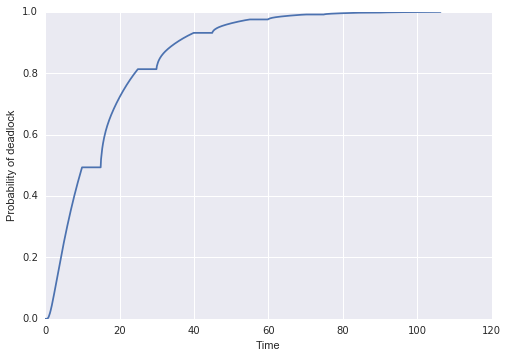

In [63]:
plt.figure()
plt.plot(time_steps, cdf)
plt.xlabel("Time")
plt.ylabel("Probability of deadlock");

In [58]:
Ls = [1.0, 2.0, 3.0, 4.0, 5.0]
ts = []
timesteps = []
for l in Ls:
    time_steps, pdf, cdf = obtain_probability_distributions(n, mu, r11, l, schedule_lengths, stopping_probability = .999)
    ts.append(cdf)
    timesteps.append(time_steps)

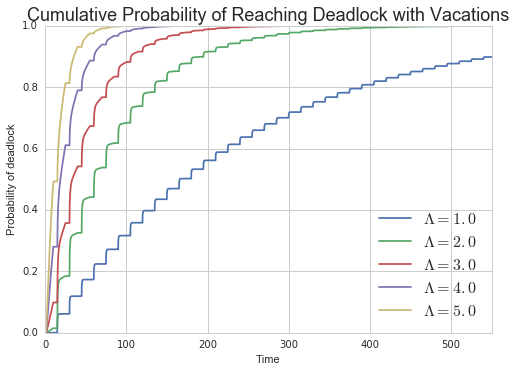

In [71]:
plt.figure()
plt.plot(timesteps[0], ts[0], label=r"$\Lambda = 1.0$")
plt.plot(timesteps[1], ts[1], label=r"$\Lambda = 2.0$")
plt.plot(timesteps[2], ts[2], label=r"$\Lambda = 3.0$")
plt.plot(timesteps[3], ts[3], label=r"$\Lambda = 4.0$")
plt.plot(timesteps[4], ts[4], label=r"$\Lambda = 5.0$")
plt.xlabel("Time")
plt.ylim([0, 1])
plt.xlim([0, 550])
plt.ylabel("Probability of deadlock")
plt.legend(loc=4, fontsize=16)
plt.title("Cumulative Probability of Reaching Deadlock with Vacations", fontsize=18)
plt.savefig("cdf_varylambda.pdf")